In [41]:
import csv
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.base import clone
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_decomposition import CCA

from sklearn.feature_selection import SelectKBest, chi2

import warnings

warnings.filterwarnings('ignore')

"""
readFile：读取原始TCR-epitope数据函数
filePath:原始数据文件路径
key_fields:要存储的键值List，从前往后范围减小
value_fields:要存储的内容List，内容不分先后
delimiter:csv.DictReader参数，换行符标志
返回值：返回一个dict
"""
def readFile(filePath, key_fields, value_fields, delimiter = '\t'):
    retDict = {}
    with open(filePath, newline='') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=delimiter)
        for row in reader:
            keys = [row[k] for k in key_fields]
            values = [row[s] for s in value_fields]
            sub_dict = retDict
            for key in keys[:-1]:
                if key not in sub_dict:
                    sub_dict[key] = {}
                sub_dict = sub_dict[key]
            key = keys[-1]
            if key not in sub_dict:
                sub_dict[key] = []
            sub_dict[key].append(values)

    return retDict

"""
dataPreprocess:对数进行预处理，统计不同表位的可用数据并加以筛选
dataDict:输入的原始Dict格式数据
species:要处理的种族数据，如HomoSapiens或者MusMusculus
gene:要处理的基因类型，如TRB或TRA
miniValue:筛选epitope的最小数据量
返回值：返回一个dict
"""
def dataPreprocess(dataDict, species, gene, miniValue=50):
    retDict = {}
    for s in species:
        for g in gene:
            epitopeList = list(dataDict[s][g].keys())
            for epi in epitopeList:
                epiSize = len(dataDict[s][g][epi])
                if epiSize >= miniValue:
                    retDict[epi] = dataDict[s][g][epi]
                    for i in range(epiSize):
                        meta = ast.literal_eval(retDict[epi][i][4])
                        sub_id = meta['subject.id']
                        reference = retDict[epi][i][3]
                        retDict[epi][i][3] = reference + '_' + sub_id
                        retDict[epi][i] = retDict[epi][i][:-1]
    return retDict


def statisticsEpitope(epiDict, path='data/epiDict.csv'):
    print('{:22s} {:s}'.format('Epitope', 'Number'))
    with open(path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['epitope', 'info'])
        for epi in epiDict:
            print('{:22s} {:d}'.format(epi, len(epiDict[epi])))
            for item in epiDict[epi]:
                writer.writerow([epi, item])

    print("epiDict have been saved in: {:s}".format(path))


def removeDuplicates(epiDict):
    ret_dict = {}
    for epi in epiDict:
        item_list = []
        item_dict = set()
        for item in epiDict[epi]:
            if item[0] not in item_dict:
                item_list.append(item)
                item_dict.add(item[0])
        ret_dict[epi] = item_list
    return ret_dict


def saveEpitope(epiDict, path):
    with open(path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['epitope', 'cdr3b', 'vb_gene', 'vj_gene'])
        for epi in epiDict:
            for item in epiDict[epi]:
                writer.writerow([epi, item[0], item[1], item[2]])

    print("Epitope-TCR pairs have been saved in: {:s}".format(path))

def splitCDR(CDRseq, k = 3):
    retDict = []
    for i in range(len(CDRseq) - k + 1):
        retDict.append(CDRseq[i:i+k])
    return retDict


def statisticsKmer(epiDict, k=3):
    kmerDict = {}
    for epi in epiDict:
        for i in range(len(epiDict[epi])):
            splitList = splitCDR(epiDict[epi][i], k)
            for split in splitList:
                if split not in kmerDict:
                    kmerDict[split] = 1
                else:
                    kmerDict[split] += 1
    return kmerDict


def buildFeatures(epiDict, kmerDict, k=3,
                  return_kmers=False):
    counter = 0
    for epi in epiDict:
        counter += len(epiDict[epi])
    retArr = np.zeros((counter, len(kmerDict)))

    kmerList = list(kmerDict.keys())
    retLabel = []

    iter = 0
    epinum = 0
    for epi in epiDict:
        for cdr in range(len(epiDict[epi])):
            splitlist = splitCDR(epiDict[epi][cdr], k)
            retLabel.append(epinum)
            i = 0
            for kmer in kmerList:
                retArr[iter][i] = splitlist.count(kmer)
                i += 1
            iter += 1
        epinum += 1

    if not return_kmers:
        return np.array(retArr), np.array(retLabel)
    else:
        return np.array(retArr), np.array(retLabel), kmerList


def _cal_micro_ROC(y_test, y_score):
    """Calculate the micro ROC value"""
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    return fpr, tpr, auc(fpr, tpr)


def _cal_macro_ROC(y_test, y_score, fpr, tpr, n_classes):
    """Calculate the macro ROC value"""
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)


def _plot_roc_curves(fpr, tpr, roc_auc, epi_list, title):
    """PLot the ROC curve"""
    mean_fpr = np.linspace(0, 1, 200)
    tprs = list()
    aucs = list()
    for i in range(len(epi_list)):
        tprs.append(interp(mean_fpr, fpr[i], tpr[i]))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc[i])
        cur_auc = round(roc_auc[i], 3)
        plt.plot(fpr[i], tpr[i], lw=1, alpha=0.5, label='{0}({1})'.format(epi_list[i], str(cur_auc)))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(tprs, axis=0)
    plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC({})'.format(round(mean_auc, 3)), lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=.2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


def _cal_roc_auc(y_test, y_score, y_pred, epi_list, draw_roc_curve=True, title="ROC curves"):
    """"Calculate the AUROC value and draw the ROC curve."""
    fpr = dict()
    tpr = dict()
    precision = list()
    recall = list()
    roc_auc = dict()
    y_test = label_binarize(y_test, classes=np.arange(len(epi_list)))
    y_pred = label_binarize(y_pred, classes=np.arange(len(epi_list)))
    for i in range(len(epi_list)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision.append(precision_score(y_test[:, i], y_pred[:, i]))
        recall.append(recall_score(y_test[:, i], y_pred[:, i]))

    # micro-average ROC
    fpr["micro"], tpr["micro"], roc_auc["micro"] = _cal_micro_ROC(y_test, y_score)

    # macro-average ROC
    fpr["macro"], tpr["macro"], roc_auc["macro"] = _cal_macro_ROC(y_test, y_score, fpr, tpr, len(epi_list))

    # plot all ROC curves
    if draw_roc_curve:
        _plot_roc_curves(fpr, tpr, roc_auc, epi_list, title)

    return roc_auc, np.mean(precision), np.mean(recall)


def predict_auc(X, y, classifier, cv, epi_list, draw_roc_curve=True, title="ROC curves"):
    auc_dict = {}
    acc_list, precision_list, recall_list = [], [], []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=666)
    cur_fold = 1
    for train_index, test_index in skf.split(X, y):
        # split cross-validation folds
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, X_test = pca_analyse(X_train, X_test, 0.9)

        clf = clone(classifier)
        clf.fit(X_train, y_train)

        acc_list.append(clf.score(X_test, y_test))

        y_prob = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)

        auc_dict[cur_fold], precision, recall = _cal_roc_auc(y_test, y_prob, y_pred, epi_list, draw_roc_curve)

        precision_list.append(precision)
        recall_list.append(recall)
        cur_fold += 1

    return auc_dict, acc_list, precision_list, recall_list


def pca_analyse(X_train, X_test, rate=0.9):
    """Perform PCA for the train set and test set."""
    pca = PCA(n_components=rate).fit(X_train)
    return pca.transform(X_train), pca.transform(X_test)


def cca_analyse(X_train, y_train, X_test, n_components=100):
    """Perform CCA for the train set and test set."""
    cca = CCA(n_components=n_components).fit(X_train, y_train)
    return cca.transform(X_train), cca.transform(X_test)


def kernel_pca_analyse(X_train, X_test, kernel, rate=0.9):
    """Perform kernel PCA for the train set and test set."""
    pca = KernelPCA(n_components=rate, kernel=kernel)
    return pca.transform(X_train), pca.transform(X_test)


def data_preprocess(file, k=3, remove_duplicate=False,
                    return_kmers=False, min_tcrs_amount=10):
    print("Reading file: ", file)
    df = pd.read_csv(file)

    if remove_duplicate:
        head_list = df.columns.values.tolist()
        assert 'antigen.epitope' in head_list and 'cdr3_b_aa' in head_list and 'v_b_gene' in head_list
        subset = ['antigen.epitope', 'cdr3_b_aa', 'v_b_gene']
        if 'v_b_gene' in head_list:
            df.drop_duplicates(subset=subset, inplace=True)

    epiDict = {}
    for index, row in df.iterrows():
        if row['antigen.epitope'] not in epiDict:
            epiDict[row['antigen.epitope']] = []
        epiDict[row['antigen.epitope']].append(row['cdr3_b_aa'])

    # Threshold：10, only epitopes with binding tcr sequences over 10 are remained.
    epiDict_filtered = {}
    for epi in epiDict:
        if len(epiDict[epi]) > min_tcrs_amount:
            epiDict_filtered[epi] = epiDict[epi]
    epiDict = epiDict_filtered

    statistics_epi = []
    statistics_num = []
    print('{:22s} {:s}'.format('antigen.epitope', 'Number'))
    for epi in epiDict:
        statistics_epi.append(epi)
        statistics_num.append(len(epiDict[epi]))
        print('{:22s} {:d}'.format(epi, len(epiDict[epi])))

    kmerDict = statisticsKmer(epiDict, k)

    if not return_kmers:
        X, y = buildFeatures(epiDict, kmerDict, k)
        return X, y, list(epiDict.keys())
    else:
        X, y, kmers_list = buildFeatures(epiDict, kmerDict, k, return_kmers=True)
        return X, y, list(epiDict.keys()), kmers_list



def draw_heatmap(X, y):
    print('ploting heatmap ...')
    sns.heatmap(np.c_[X, y], cmap=sns.cm.rocket_r)
    plt.show()


def make_table(auc_dict, acc_list, precision_list, recall_list, cv=5):
    # record auc result for each fold of cross-validation
    table = np.array([0]*(4*(cv+1)), dtype=np.float16).reshape((cv+1, 4))
    for fold in auc_dict:
        table[fold-1][0] = auc_dict[fold]['macro']
    for i in range(cv):
        table[i][1] = acc_list[i]
        table[i][2] = precision_list[i]
        table[i][3] = recall_list[i]
    for i in range(4):
        table[cv][i] = np.mean(table[:-1,i])
    return table

# SETE
Sequence-based Ensemble learning approach for TCR Epitope binding prediction

## 1 import packages

Some Python packages you need to install:

- numpy
- pandas
- plotly
- seaborn
- matplotlib
- scikit-learn
- scipy

In [37]:
import numpy as np
import pandas as pd
import collections
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#from SETE import *
from itertools import cycle
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy import interp
from sklearn.base import clone
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_decomposition import CCA

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import GradientBoostingClassifier

import warnings

warnings.filterwarnings('ignore')

## 2 Basic I/O functions definition
Define the I/O functions which transform the raw data into the csv or tsv file that the software knows.

Your input csv/tsv file must at least contains the following columns:

- epitope
- cdr3b
- vb_gene
- [jb_gene]

In [47]:
def _read_raw_data(file_path):
    file_type = file_path[-3:]
    assert file_type == 'csv' or file_type == 'tsv', "The input file must be csv or tsv file."
    if file_type == 'csv':
        df = pd.read_csv(file_path)
    else:
        df = pd.read_csv(file_path, sep='\t')
    return df

def read_data(file_path):
    raw_data_df = _read_raw_data(file_path)
    raw_data_columns = raw_data_df.columns.values.tolist()
    assert 'antigen.epitope' in raw_data_columns and 'cdr3.beta' in raw_data_columns, "Columns 'Epitope' and 'CDR3' must in the input file."
    data_df = pd.DataFrame(raw_data_df[['antigen.epitope', 'cdr3.beta']])
    return data_df

In [48]:
input_file_path = '/content/df_slim.csv'
data = pd.read_csv(input_file_path)
data.head()

,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,Nef,FLKEKGGL
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEQGGL


## 3 Data exploration

Data visualization

In [50]:
#input_file_path = '/content/epitope_tcr_pairs.csv'
#data = read_data(input_file_path)
px.scatter(data, x="antigen.epitope", y="cdr3_b_aa", color="antigen.epitope",
           marginal_y="histogram", marginal_x="histogram", render_mode="svg")

# import plotly
# plotly.offline.plot(st)

In [51]:
classes = data['antigen.epitope'].unique()
print(classes)

['FLKEKGGL' 'FLKEQGGL' 'FLKETGGL' 'FLKEMGGL' 'ELAGIGILTV'
 'TAAQAAVVRFQEAAN' 'MHVSFVMAYPEMLAA' 'PSPSMGRDIKVQFQS' 'MSQIMYNYPAMLGHA'
 'AAVVRFQEAANKQKQ' 'PPQIAANRSQLISLV' 'STRQALRPRADGPVG' 'LTDEQRAAALEKAAA'
 'LLFGYPVYV' 'GNSHRGAIEWEGIESG' 'INFDFNTI' 'PKYVKQNTLKLAT' 'SIYRYYGL'
 'KVITFIDL' 'FLRGRAYGL' 'EQYKFYSV' 'RGYVYQGL' 'GILGFVFTL' 'LLFGYAVYV'
 'LLFGYPRYV' 'LLFGYPVAV' 'SRGGASQYRPSQ' 'VHFFKNIVTPRTPG' 'LPEPLPQGQLTAY'
 'SLLMWITQV' 'SLLMWITQC' 'VMAPRTLIL' 'LLFGKPVYV' 'GELIGILNAAKVPAD'
 'GELIGTLNAAKVPAD' 'EPLPQGQLTAY' 'SQYYYNSL' 'RGGASQYRPSQ' 'KAFSPEVIPMF'
 'LLFGPVYV' 'EENLLDFVRF' 'NLVPMVATV' 'MLWGYLQYV' 'EEYLKAWTF' 'EEYLQAFTY'
 'GAMKRHGLDNYRGYSLG' 'HPVGEADYFEY' 'GLCTLVAML' 'SSLENFRAYV' 'LGYGFVNYI'
 'AAGIGILTV' 'LLFGFPVYV' 'ADLIAYLKQATKG' 'WIYVYRPMGCGGS' 'ALWGPDPAAA'
 'RFPLTFGWCF' 'RYPLTFGWCF' 'RYPLTLGWCF' 'ALGIGILTV' 'KRWIILGLNK'
 'KRWIIMGLNK' 'SGEGSFQPSQENP' 'ELAAIGILTV' 'ELAGIGALTV' 'TAFTIPSI'
 'ILAKFLHWL' 'APQPELPYPQPGS' 'APQPELPYPQPG' 'QPFPQPELPYP'
 'PADPLAFFSSAIKGGGGSLV' 'ADGLAYFRSSFKGG

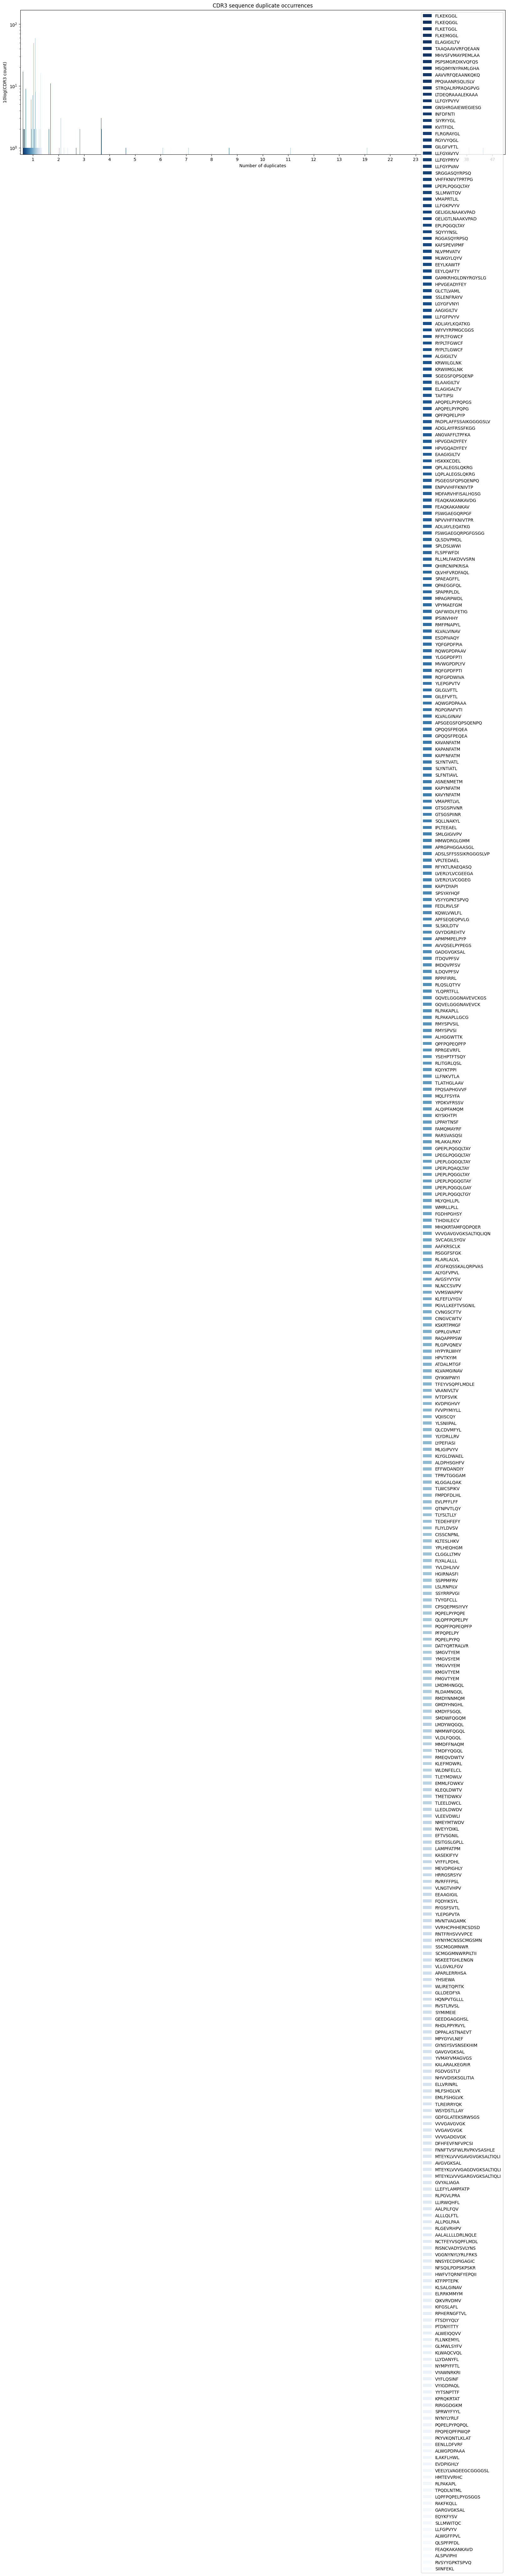

In [54]:
# plot the number of duplicates per CDR3 sequence
counts = []
for peptide in classes:
    count = data[data['antigen.epitope'] == peptide]['cdr3_b_aa'].value_counts()
    counts.append(pd.DataFrame({'counts': count, 'peptide': [peptide] * len(count)}))

plt.figure(figsize=(20, 6))

sns.countplot(x='counts', hue='peptide', data=pd.concat(counts), palette='Blues_r')

plt.yscale('log')

plt.title('CDR3 sequence duplicate occurrences')

plt.xlabel('Number of duplicates')
plt.ylabel('10log(CDR3 count)')

plt.legend(loc='upper right', frameon=True)

plt.savefig('CDR3sequence_distribution.pdf', bbox_inches='tight', dpi=600)
plt.show()
plt.close()

In [56]:
cdr3_count = pd.concat(counts)
cdr3_count.tail()

,counts,peptide
CASSFRSTDTQYF,1,PQPELPYPQPQL
CASSLRATDTQYF,1,PQPELPYPQPQL
CASSSLTSGILGEQFF,1,FPQPEQPFPWQP
CATSRAGGGGEKLFF,1,FPQPEQPFPWQP
CASSQGSGGNEQFF,1,FPQPEQPFPWQP


In [57]:
px.histogram(cdr3_count, x="counts", y="peptide", color="peptide", marginal="rug")

In [58]:
X, y, epiname_list = data_preprocess(input_file_path, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

Reading file:  /content/df_slim.csv
antigen.epitope        Number
ELAGIGILTV             23
GILGFVFTL              250
EPLPQGQLTAY            15
NLVPMVATV              461
HPVGEADYFEY            15
GLCTLVAML              72
SSLENFRAYV             130
TAFTIPSI               17
EAAGIGILTV             15
KLVALGINAV             40
ASNENMETM              136
HMTEVVRHC              11
YLQPRTFLL              65
RPRGEVRFL              68
CVNGSCFTV              14
CINGVCWTV              21
QYIKWPWYI              51
TFEYVSQPFLMDLE         87
VAANIVLTV              15
HGIRNASFI              102
SSPPMFRV               106
LSLRNPILV              62
SSYRRPVGI              261
TVYGFCLL               63
PFPQPELPY              13
DATYQRTRALVR           20
LLEFYLAMPFATP          13
RLPGVLPRA              13
NCTFEYVSQPFLMDL        16
HWFVTQRNFYEPQII        16
SPRWYFYYL              22


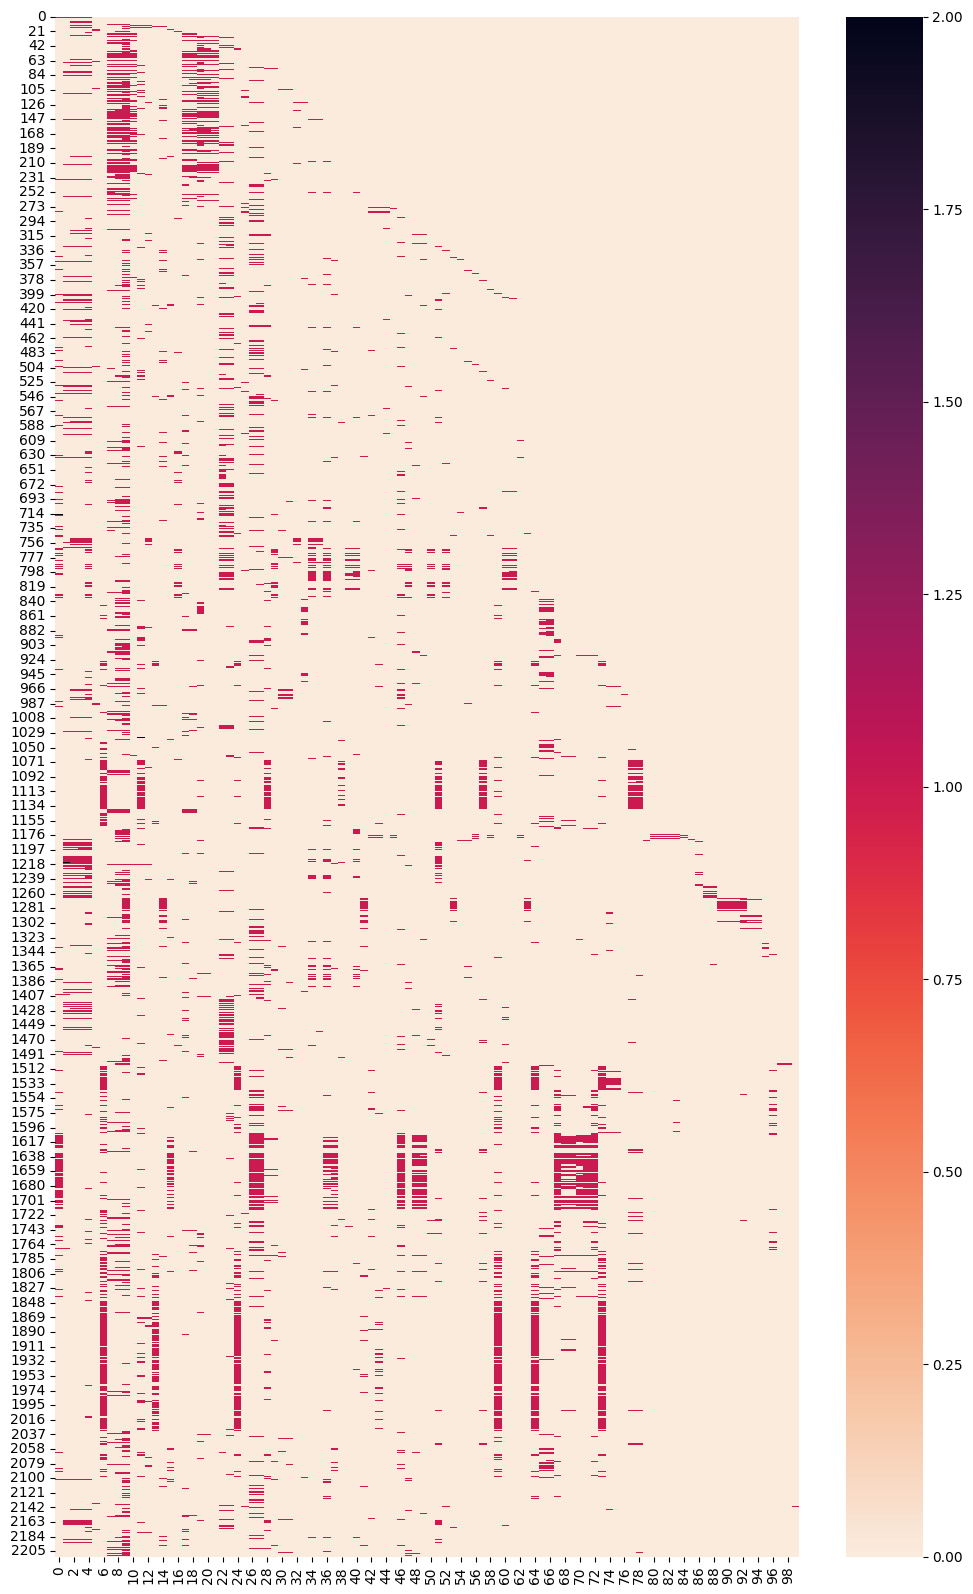

In [59]:
newX = SelectKBest(chi2, k=100).fit_transform(X, y)
newX = pd.DataFrame(newX)
plt.figure(figsize=(12, 20))
sns.heatmap(newX, cmap=sns.cm.rocket_r)
plt.show()
# px.density_heatmap(newX)

## 4 Evaluation
Test the performance of our model here.

The `input_file_path` is the path of your input file.

In [60]:
X, y, epiname_list = data_preprocess(input_file_path, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

Reading file:  /content/df_slim.csv
antigen.epitope        Number
ELAGIGILTV             23
GILGFVFTL              250
EPLPQGQLTAY            15
NLVPMVATV              461
HPVGEADYFEY            15
GLCTLVAML              72
SSLENFRAYV             130
TAFTIPSI               17
EAAGIGILTV             15
KLVALGINAV             40
ASNENMETM              136
HMTEVVRHC              11
YLQPRTFLL              65
RPRGEVRFL              68
CVNGSCFTV              14
CINGVCWTV              21
QYIKWPWYI              51
TFEYVSQPFLMDLE         87
VAANIVLTV              15
HGIRNASFI              102
SSPPMFRV               106
LSLRNPILV              62
SSYRRPVGI              261
TVYGFCLL               63
PFPQPELPY              13
DATYQRTRALVR           20
LLEFYLAMPFATP          13
RLPGVLPRA              13
NCTFEYVSQPFLMDL        16
HWFVTQRNFYEPQII        16
SPRWYFYYL              22


### Accuracy

In [61]:
classifier = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=0.1,
                                min_samples_leaf=20, max_features='sqrt', subsample=0.8,
                                random_state=10, n_estimators=70, max_depth=10,
                                min_samples_split=60, loss="deviance"
                                ))

X_train, X_test = pca_analyse(X_train, X_test, 0.9)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.5891647855530474

In [62]:
classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=20, max_features='sqrt', subsample=0.8,
                                        random_state=666, n_estimators=70, max_depth=11,
                                        min_samples_split=60, loss="deviance"
                                        )

X_train, X_test = pca_analyse(X_train, X_test, 0.9)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.6139954853273137

In [65]:
def cross_validation(X, y, clf, transform='pca', splits=5, random_seed=666):
    skf = StratifiedKFold(n_splits=splits, random_state=random_seed, shuffle=True)
    accuracy_list, recall_list = [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if transform == 'pca':
            X_train, X_test = pca_analyse(X_train, X_test, 0.9)
        elif transform == 'cca':
            X_train, X_test = cca_analyse(X_train, y_train, X_test, 100)
        else:
            raise ValueError

        classifier = clone(clf)
        classifier.fit(X_train, y_train)
        accuracy_list.append(classifier.score(X_test, y_test))
    return accuracy_list

In [66]:
X, y, epiname_list = data_preprocess('/content/df_slim.csv', 3, True)

c1 = GradientBoostingClassifier()
c2 = OneVsRestClassifier(GradientBoostingClassifier())
c3 = GradientBoostingClassifier(learning_rate=0.1,
                                min_samples_leaf=20, max_features='sqrt', subsample=0.8,
                                random_state=666, n_estimators=70, max_depth=11,
                                min_samples_split=60, loss="deviance"
                                )

result1 = cross_validation(X, y, c1)
print(result1)
result2 = cross_validation(X, y, c2)
print(result2)
result3 = cross_validation(X, y, c3)
print(result3)

Reading file:  /content/df_slim.csv
antigen.epitope        Number
ELAGIGILTV             20
GILGFVFTL              131
EPLPQGQLTAY            12
NLVPMVATV              278
GLCTLVAML              43
SSLENFRAYV             93
TAFTIPSI               11
EAAGIGILTV             15
KLVALGINAV             39
ASNENMETM              72
YLQPRTFLL              51
RPRGEVRFL              29
CVNGSCFTV              14
CINGVCWTV              21
QYIKWPWYI              50
TFEYVSQPFLMDLE         85
VAANIVLTV              14
HGIRNASFI              74
SSPPMFRV               40
LSLRNPILV              56
SSYRRPVGI              185
TVYGFCLL               54
PFPQPELPY              13
DATYQRTRALVR           20
LLEFYLAMPFATP          13
RLPGVLPRA              13
NCTFEYVSQPFLMDL        16
HWFVTQRNFYEPQII        16
SPRWYFYYL              21


KeyboardInterrupt: 

In [ ]:
# Dash_mouse ACC
[0.7036082474226805, 0.6847545219638242, 0.734375, 0.6762402088772846, 0.6832460732984293]
[0.6907216494845361, 0.6744186046511628, 0.7552083333333334, 0.6736292428198434, 0.6963350785340314]
[0.6907216494845361, 0.6770025839793282, 0.75, 0.6892950391644909, 0.725130890052356]

# Dash_mouse ACC
[0.7619047619047619, 0.8292682926829268, 0.8292682926829268, 0.8170731707317073, 0.7317073170731707]
[0.7619047619047619, 0.8292682926829268, 0.8048780487804879, 0.7926829268292683, 0.7439024390243902]
[0.7619047619047619, 0.8170731707317073, 0.7804878048780488, 0.8048780487804879, 0.7073170731707317]

# Dash_human ACC - remove duplicated
[0.521551724137931, 0.5324675324675324, 0.5304347826086957, 0.4847161572052402, 0.43859649122807015]
[0.49137931034482757, 0.5454545454545454, 0.5347826086956522, 0.4672489082969432, 0.4649122807017544]
[0.5172413793103449, 0.5238095238095238, 0.5434782608695652, 0.45414847161572053, 0.4605263157894737]

[0.7619047619047619,
 0.8170731707317073,
 0.7804878048780488,
 0.8048780487804879,
 0.7073170731707317]

### Area under receiver operating characteristic curves

Reading file:  /content/df_slim.csv
antigen.epitope        Number
ELAGIGILTV             23
GILGFVFTL              250
EPLPQGQLTAY            15
NLVPMVATV              461
HPVGEADYFEY            15
GLCTLVAML              72
SSLENFRAYV             130
TAFTIPSI               17
EAAGIGILTV             15
KLVALGINAV             40
ASNENMETM              136
HMTEVVRHC              11
YLQPRTFLL              65
RPRGEVRFL              68
CVNGSCFTV              14
CINGVCWTV              21
QYIKWPWYI              51
TFEYVSQPFLMDLE         87
VAANIVLTV              15
HGIRNASFI              102
SSPPMFRV               106
LSLRNPILV              62
SSYRRPVGI              261
TVYGFCLL               63
PFPQPELPY              13
DATYQRTRALVR           20
LLEFYLAMPFATP          13
RLPGVLPRA              13
NCTFEYVSQPFLMDL        16
HWFVTQRNFYEPQII        16
SPRWYFYYL              22


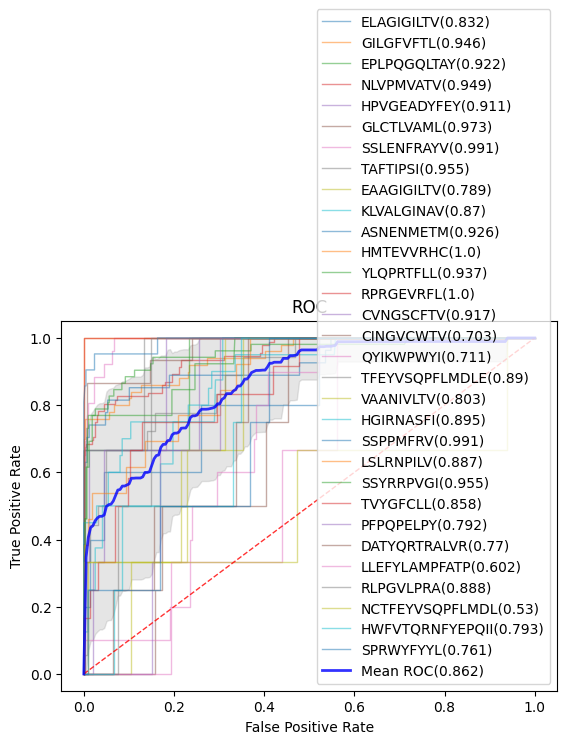

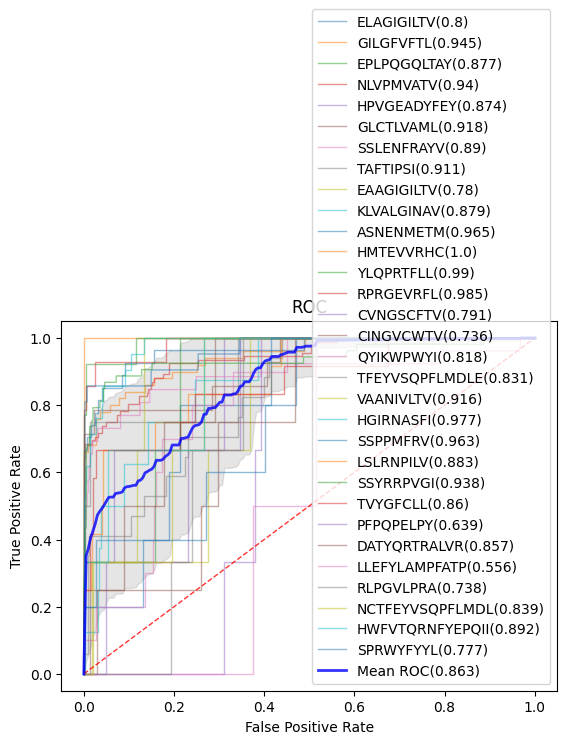

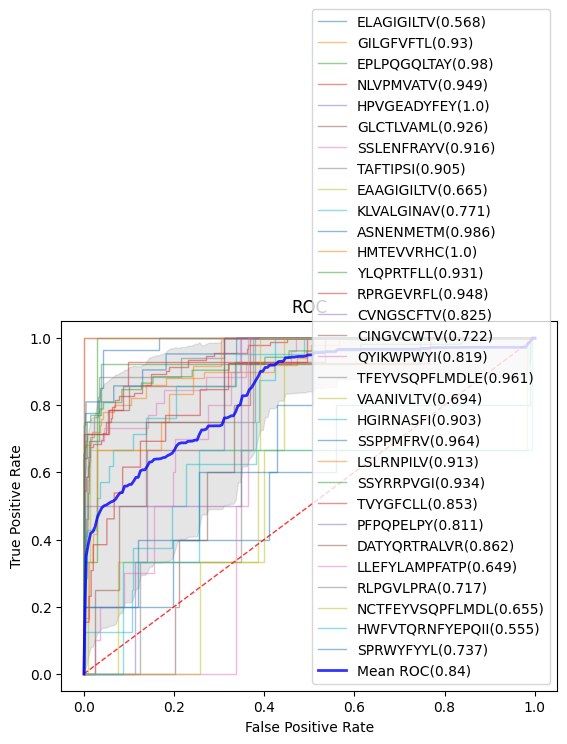

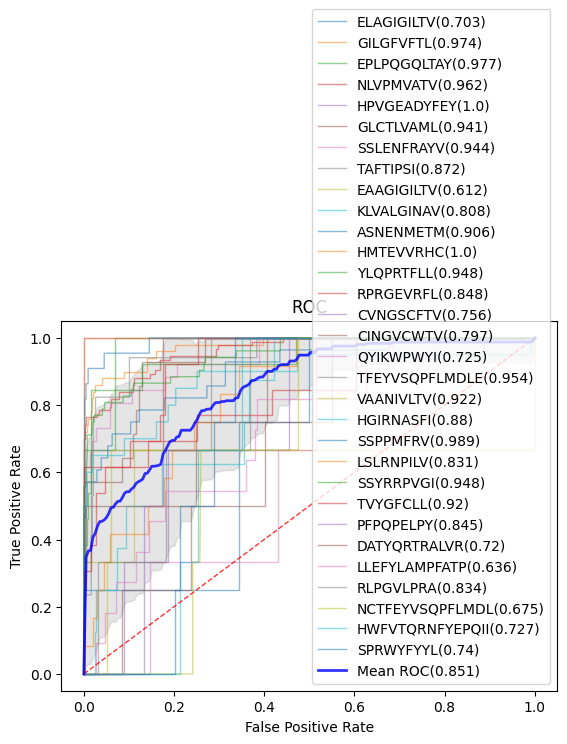

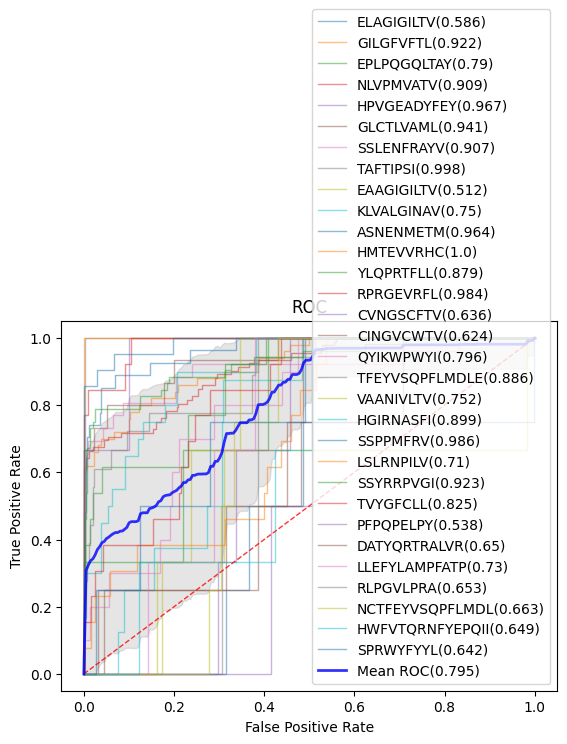

In [67]:
X, y, epiname_list = data_preprocess('/content/df_slim.csv', 3)
classifier = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', subsample=0.8,
                                random_state=10, n_estimators=70, max_depth=10, loss="deviance"
                                ))
auc_result, acc, precision, recall = predict_auc(X, y, classifier, 5, epiname_list)

Reading file:  ./data/Dash/Dash_mouse.csv
Epitope                Number
PB1                    642
M45                    291
F2                     117
PA                     324
NP                     305
M38                    158
m139                   87


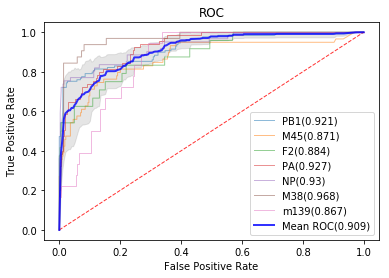

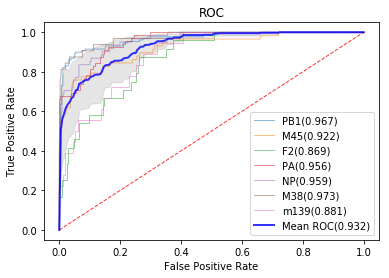

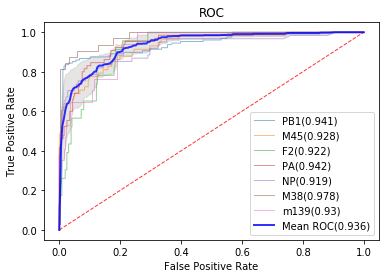

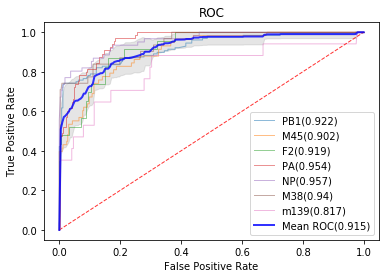

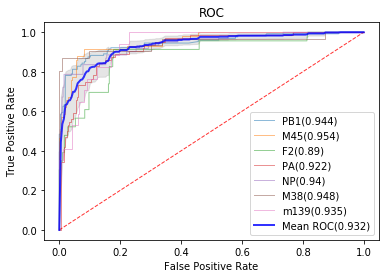

In [ ]:
X, y, epiname_list = data_preprocess('./data/Dash/Dash_mouse.csv', 3)
classifier = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', subsample=0.8,
                                random_state=10, n_estimators=70, max_depth=10, loss="deviance"
                                ))
auc_result, acc, precision, recall = predict_auc(X, y, classifier, 5, epiname_list, True)

### Detail Table

In [68]:
def make_table(auc_dict, acc_list, precision_list, recall_list, cv=5):
    # record auc result for each fold of cross-validation
    table = np.array([0]*(4*(cv+1)), dtype=np.float16).reshape((cv+1, 4))
    for fold in auc_dict:
        table[fold-1][0] = auc_dict[fold]['macro']
    for i in range(cv):
        table[i][1] = acc_list[i]
        table[i][2] = precision_list[i]
        table[i][3] = recall_list[i]
    for i in range(4):
        table[cv][i] = np.mean(table[:-1,i])
    return table

#### Classification report for Dash_human

In [69]:
pd.DataFrame(make_table(auc_result, acc, precision, recall), columns=['AUROC', 'Accuracy', 'Precision', 'Recall'], index=['Fold {}'.format(i+1) if i < 5 else 'Avg.' for i in range(6) ])

,AUROC,Accuracy,Precision,Recall
Fold 1,0.863281,0.634277,0.491211,0.371826
Fold 2,0.863770,0.616211,0.499023,0.357178
Fold 3,0.840820,0.589355,0.467773,0.351807
Fold 4,0.851562,0.610840,0.484131,0.336670
Fold 5,0.796387,0.577148,0.419189,0.303955
Avg.,0.843262,0.605469,0.472168,0.344238


#### Classification report for Dash_mouse
Please ignore the Accuracy score :)

In [ ]:
pd.DataFrame(make_table(auc_result, acc, precision, recall), columns=['AUROC', 'Accuracy', 'Precision', 'Recall'], index=['Fold {}'.format(i+1) if i < 5 else 'Avg.' for i in range(6) ])

,AUROC,Accuracy,Precision,Recall
Fold 1,0.889648,0.554199,0.965332,0.437744
Fold 2,0.868652,0.537598,0.770508,0.435547
Fold 3,0.889160,0.619629,0.857422,0.498047
Fold 4,0.866211,0.542969,0.939453,0.447754
Fold 5,0.881836,0.575684,0.814941,0.469482
Avg.,0.878906,0.565918,0.869629,0.457764


### AUROC table for Dash dataset

In [ ]:
def make_auc_table(cv=5):
    # record auc result for each fold of cross-validation
    file_path_list = ['./data/Dash/Dash_human.csv', './data/Dash/Dash_mouse.csv']
    classifier = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=0.1,
                                min_samples_leaf=20, max_features='sqrt', subsample=0.8,
                                random_state=666, n_estimators=70, max_depth=11,
                                min_samples_split=60, loss="deviance"
                                ))
    ret_df = pd.DataFrame()

    for file_path in file_path_list:
        X, y, epiname_list = data_preprocess(file_path, 3, False)
        auc_result, acc, pre, rec = predict_auc(X, y, classifier, cv, epiname_list, False)
        df = pd.DataFrame(columns=['Fold-{}'.format(i+1)for i in range(cv)], index=epiname_list)
        for fold in auc_result:
            df.loc[:,"Fold-{}".format(fold)] = [round(auc_result[fold][i], 3) for i in range(len(epiname_list))]

        ret_df = pd.concat([ret_df, df])

    ret_df["Avg."] = round(ret_df.mean(axis=1),3)
    ret_df['Std.'] = round(ret_df.std(axis=1),3)
    ret_df.index = [["human", "human", "human", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse"], ret_df.index]

    return ret_df


In [ ]:
make_auc_table()

Reading file:  ./data/Dash/Dash_human.csv
Epitope                Number
pp65                   61
BMLF                   76
M1                     275
Reading file:  ./data/Dash/Dash_mouse.csv
Epitope                Number
F2                     117
PA                     324
M45                    291
NP                     305
M38                    158
m139                   87
PB1                    642


Fold-1  Fold-2  Fold-3  Fold-4  Fold-5   Avg.   Std.
human pp65   0.831   0.854   0.954   0.933   0.813  0.877  0.056
      BMLF   0.965   0.812   0.956   0.968   0.964  0.933  0.061
      M1     0.879   0.902   0.946   0.954   0.840  0.904  0.042
mouse F2     0.826   0.838   0.878   0.810   0.853  0.841  0.023
      PA     0.924   0.910   0.899   0.866   0.864  0.893  0.024
      M45    0.826   0.826   0.878   0.816   0.821  0.833  0.023
      NP     0.923   0.798   0.867   0.860   0.851  0.860  0.040
      M38    0.871   0.879   0.906   0.848   0.884  0.878  0.019
      m139   0.694   0.902   0.720   0.694   0.660  0.734  0.086
      PB1    0.801   0.788   0.868   0.800   0.781  0.808  0.031

#### version2 (For paper)

In [ ]:
def make_auc_table(cv=5):
    # record auc result for each fold of cross-validation
    file_path_list = ['./data/Dash/Dash_human.csv', './data/Dash/Dash_mouse.csv']
    classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=10)
    ret_df = pd.DataFrame()

    for file_path in file_path_list:
        X, y, epiname_list = data_preprocess(file_path, 3, False)
        auc_result, acc, pre, rec = predict_auc(X, y, classifier, cv, epiname_list, False)
        df = pd.DataFrame(columns=['Fold-{}'.format(i+1)for i in range(cv)], index=epiname_list)
        for fold in auc_result:
            df.loc[:,"Fold-{}".format(fold)] = [round(auc_result[fold][i], 3) for i in range(len(epiname_list))]

        ret_df = pd.concat([ret_df, df])

    ret_df["Avg."] = round(ret_df.mean(axis=1),3)
    ret_df['Std.'] = round(ret_df.std(axis=1),3)
    ret_df.index = [["human", "human", "human", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse"], ret_df.index]

    return ret_df

make_auc_table()

Reading file:  ./data/Dash/Dash_human.csv
Epitope                Number
pp65                   61
BMLF                   76
M1                     275
Reading file:  ./data/Dash/Dash_mouse.csv
Epitope                Number
F2                     117
PA                     324
M45                    291
NP                     305
M38                    158
m139                   87
PB1                    642


Fold-1  Fold-2  Fold-3  Fold-4  Fold-5   Avg.   Std.
human pp65   0.701   0.885   0.852   0.923   0.865  0.845  0.076
      BMLF   0.941   0.918   0.955   0.954   0.960  0.946  0.015
      M1     0.832   0.916   0.943   0.948   0.915  0.911  0.042
mouse F2     0.806   0.869   0.897   0.879   0.849  0.860  0.031
      PA     0.922   0.954   0.955   0.924   0.925  0.936  0.015
      M45    0.869   0.888   0.933   0.886   0.874  0.890  0.023
      NP     0.955   0.947   0.938   0.890   0.961  0.938  0.025
      M38    0.957   0.953   0.980   0.943   0.970  0.961  0.013
      m139   0.866   0.841   0.891   0.913   0.822  0.867  0.033
      PB1    0.920   0.946   0.952   0.924   0.925  0.933  0.013

#### Dash_remove duplicated (Data for paper)

In [ ]:
def make_auc_table(cv=5):
    # record auc result for each fold of cross-validation
    file_path_list = ['./data/Dash/Dash_human.csv', './data/Dash/Dash_mouse.csv']
    classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=10)
    ret_df = pd.DataFrame()

    for file_path in file_path_list:
        X, y, epiname_list = data_preprocess(file_path, 3, True)
        auc_result, acc, pre, rec = predict_auc(X, y, classifier, cv, epiname_list, False)
        df = pd.DataFrame(columns=['Fold-{}'.format(i+1)for i in range(cv)], index=epiname_list)
        for fold in auc_result:
            df.loc[:,"Fold-{}".format(fold)] = [round(auc_result[fold][i], 3) for i in range(len(epiname_list))]

        ret_df = pd.concat([ret_df, df])

    ret_df["Avg."] = round(ret_df.mean(axis=1),3)
    ret_df['Std.'] = round(ret_df.std(axis=1),3)
    ret_df.index = [["human", "human", "human", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse"], ret_df.index]

    return ret_df

make_auc_table()

Reading file:  ./data/Dash/Dash_human.csv
Epitope                Number
pp65                   54
BMLF                   54
M1                     150
Reading file:  ./data/Dash/Dash_mouse.csv
Epitope                Number
F2                     102
PA                     230
M45                    201
NP                     149
M38                    60
m139                   73
PB1                    335


Fold-1  Fold-2  Fold-3  Fold-4  Fold-5   Avg.   Std.
human pp65   0.639   0.641   0.707   0.774   0.788  0.710  0.063
      BMLF   0.887   0.812   0.863   0.798   0.870  0.846  0.035
      M1     0.748   0.752   0.798   0.826   0.797  0.784  0.030
mouse F2     0.691   0.730   0.785   0.719   0.808  0.747  0.043
      PA     0.862   0.858   0.785   0.827   0.837  0.834  0.028
      M45    0.724   0.669   0.706   0.692   0.753  0.709  0.028
      NP     0.746   0.721   0.762   0.784   0.857  0.774  0.046
      M38    0.840   0.646   0.800   0.692   0.661  0.728  0.078
      m139   0.560   0.742   0.557   0.686   0.727  0.654  0.080
      PB1    0.823   0.726   0.827   0.799   0.802  0.795  0.036

## *Performance of the model after removing the duplicated sequences.
*Maybe there have some mistakes in the calculation of accuracy, we will fix that problem in the near future.

### Dash_human

Reading file:  ./data/Dash/Dash_human.csv
Epitope                Number
BMLF                   55
pp65                   56
M1                     167


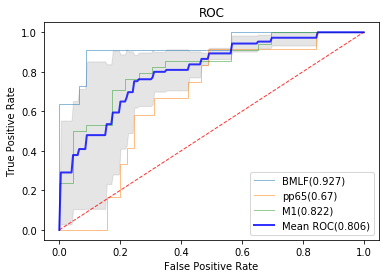

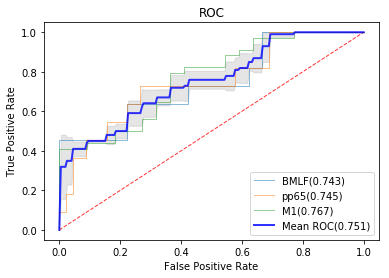

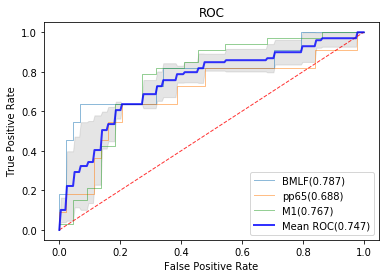

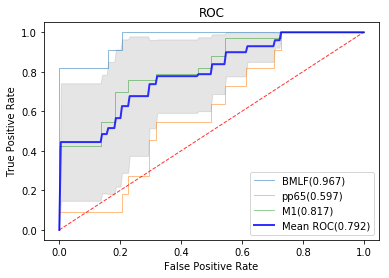

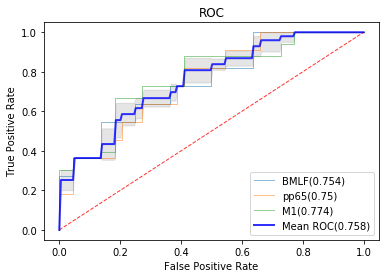

,AUROC,Accuracy,Precision,Recall
Fold 1,0.819824,0.666504,0.547363,0.454590
Fold 2,0.763672,0.678711,0.551270,0.454590
Fold 3,0.763672,0.654785,0.878418,0.424316
Fold 4,0.807129,0.690918,0.886719,0.484863
Fold 5,0.776367,0.690918,0.886719,0.484863
Avg.,0.786133,0.676270,0.750000,0.460693


In [ ]:
X, y, epiname_list = data_preprocess('./data/Dash/Dash_human.csv', 3, True)

classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=10)

auc_result, acc, precision, recall = predict_auc(X, y, classifier, 5, epiname_list, True)
pd.DataFrame(make_table(auc_result, acc, precision, recall), columns=['AUROC', 'Accuracy', 'Precision', 'Recall'], index=['Fold {}'.format(i+1) if i < 5 else 'Avg.' for i in range(6) ])

### Dash_mouse

Reading file:  ./data/Dash/Dash_mouse.csv
Epitope                Number
PB1                    408
M45                    206
F2                     103
PA                     232
NP                     151
M38                    65
m139                   73


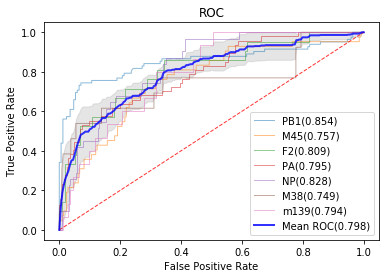

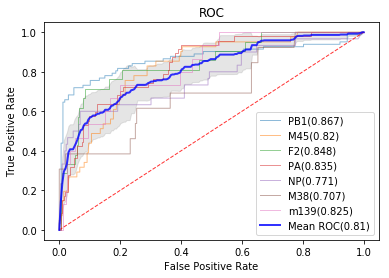

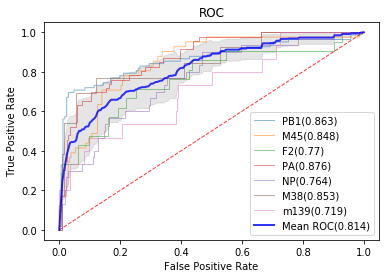

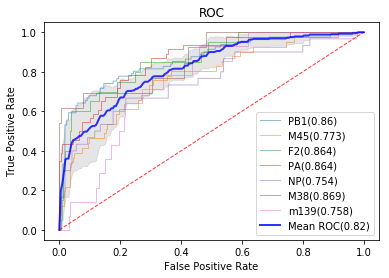

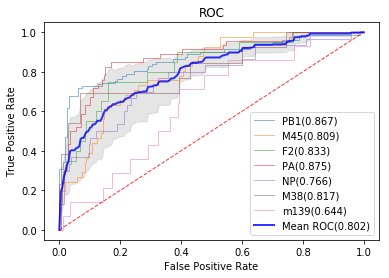

,AUROC,Accuracy,Precision,Recall
Fold 1,0.799805,0.478027,0.459473,0.325928
Fold 2,0.812500,0.541992,0.558105,0.399170
Fold 3,0.815430,0.552246,0.668457,0.403564
Fold 4,0.822266,0.538574,0.507324,0.407227
Fold 5,0.803223,0.514160,0.503418,0.351807
Avg.,0.810547,0.524902,0.539551,0.377441


In [ ]:
X, y, epiname_list = data_preprocess('./data/Dash/Dash_mouse.csv', 3, True)

classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=10)

auc_result, acc, precision, recall = predict_auc(X, y, classifier, 5, epiname_list)
pd.DataFrame(make_table(auc_result, acc, precision, recall), columns=['AUROC', 'Accuracy', 'Precision', 'Recall'], index=['Fold {}'.format(i+1) if i < 5 else 'Avg.' for i in range(6) ])

In [ ]:
def make_auc_table(cv=5):
    # record auc result for each fold of cross-validation
    file_path_list = ['./data/Dash/Dash_human.csv', './data/Dash/Dash_mouse.csv']
    classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=10)
    ret_df = pd.DataFrame()

    for file_path in file_path_list:
        X, y, epiname_list = data_preprocess(file_path, 3, True)
        auc_result, acc, pre, rec = predict_auc(X, y, classifier, cv, epiname_list, False)
        df = pd.DataFrame(columns=['Fold-{}'.format(i+1)for i in range(cv)], index=epiname_list)
        for fold in auc_result:
            df.loc[:,"Fold-{}".format(fold)] = [round(auc_result[fold][i], 3) for i in range(len(epiname_list))]

        ret_df = pd.concat([ret_df, df])

    ret_df["Avg."] = round(ret_df.mean(axis=1),3)
    ret_df['Std.'] = round(ret_df.std(axis=1),3)
    ret_df.index = [["human", "human", "human", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse", "mouse"], ret_df.index]

    return ret_df

make_auc_table()

Reading file:  ./data/Dash/Dash_human.csv
Epitope                Number
BMLF                   55
pp65                   56
M1                     167
Reading file:  ./data/Dash/Dash_mouse.csv
Epitope                Number
PB1                    408
M45                    206
F2                     103
PA                     232
NP                     151
M38                    65
m139                   73


Fold-1  Fold-2  Fold-3  Fold-4  Fold-5   Avg.   Std.
human BMLF   0.927   0.743   0.787   0.967   0.754  0.836  0.093
      pp65   0.670   0.745   0.688   0.597   0.750  0.690  0.056
      M1     0.822   0.767   0.767   0.817   0.774  0.789  0.025
mouse PB1    0.854   0.867   0.863   0.860   0.867  0.862  0.005
      M45    0.757   0.820   0.848   0.773   0.809  0.801  0.033
      F2     0.809   0.848   0.770   0.864   0.833  0.825  0.033
      PA     0.795   0.835   0.876   0.864   0.875  0.849  0.031
      NP     0.828   0.771   0.764   0.754   0.766  0.777  0.026
      M38    0.749   0.707   0.853   0.869   0.817  0.799  0.062
      m139   0.794   0.825   0.719   0.758   0.644  0.748  0.063

##